In [1]:
from tensorflow.keras.models import load_model
###### AE MODEL LOAD ######
ae_wo_classifier = load_model('model/AE_model/KERAS_check_best_model.h5')
ae_wo_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model.h5')
ae_w_classifier = load_model('model/AE_model/KERAS_check_best_model_classifier.h5')
ae_w_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model_classifier.h5')

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

In [12]:
w = ae_w_classifier_pruned.layers[2].weights[0].numpy()
print(w[0])


None


% of zeros = 0.75


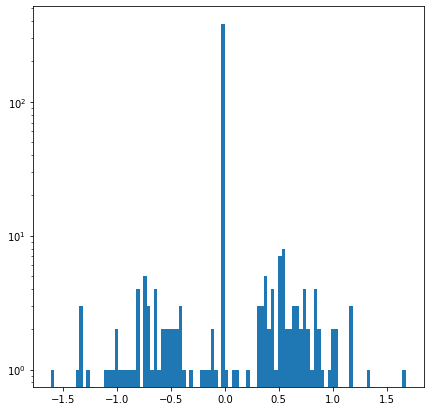

In [2]:
import numpy as np
from matplotlib import pyplot as plt

w = ae_w_classifier_pruned.layers[2].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

In [2]:
import MNIST_dataset as mnist
size_final = 10
data_zoom = mnist.MNISTData(size_final=size_final, color_depth=5)
"""
import plotting
from plotting import makeRoc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import numpy as np
model = load_model('model/AE_model/KERAS_check_model_w_classifier.h5')
#model_pruned =load_model('model/AE_model/KERAS_check_pruned_model_w_classifier.h5')

y_test = data_zoom.y_test

y_ref = model.predict(data_zoom.x_test)
#y_prune = ae_wo_classifier.predict(data_zoom.x_test)
#print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test.reshape(10000,10), axis=1), np.argmax(y_ref.reshape((10000,10)), axis=1))))
#print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = makeRoc(y_test, y_ref)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_prune, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['unpruned', 'pruned'],
            loc='lower right', frameon=False)
ax.add_artist(leg)"""

'\nimport plotting\nfrom plotting import makeRoc\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import accuracy_score\nfrom tensorflow.keras.models import load_model\nimport numpy as np\nmodel = load_model(\'model/AE_model/KERAS_check_model_w_classifier.h5\')\n#model_pruned =load_model(\'model/AE_model/KERAS_check_pruned_model_w_classifier.h5\')\n\ny_test = data_zoom.y_test\n\ny_ref = model.predict(data_zoom.x_test)\n#y_prune = ae_wo_classifier.predict(data_zoom.x_test)\n#print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test.reshape(10000,10), axis=1), np.argmax(y_ref.reshape((10000,10)), axis=1))))\n#print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))\n\nfig, ax = plt.subplots(figsize=(9, 9))\n_ = makeRoc(y_test, y_ref)\nplt.gca().set_prop_cycle(None) # reset the colors\n_ = plotting.makeRoc(y_test, y_prune, linestyle=\'--\')\n\nfrom matplotlib.lines import Line2D\nlines = [Line2D([0], [0], ls=\'-\'),\n   

# Make an hls4ml config & model

In [3]:
#import plotting
import hls4ml
config = hls4ml.utils.config_from_keras_model(ae_w_classifier_pruned, granularity='model')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(ae_w_classifier_pruned,
                                                       hls_config=config,
                                                       output_dir='model/AE_model/hls4ml_prj',
                                                       part='xc250-figd2104-2L-e')
                                                       #part='xcvu9p-flgc2104aaz')


Interpreting Model
Topology:
Layer name: encoder_input, layer type: Input
Layer name: dense_32, layer type: Dense
  -> Activation (relu), layer name: dense_32
Layer name: dense_33, layer type: Dense
  -> Activation (relu), layer name: dense_33
Layer name: encoder_output, layer type: Dense
  -> Activation (relu), layer name: encoder_output
Layer name: dense_34, layer type: Dense
  -> Activation (relu), layer name: dense_34
Layer name: dense_36, layer type: Dense
  -> Activation (relu), layer name: dense_36
Layer name: dense_35, layer type: Dense
  -> Activation (relu), layer name: dense_35
Layer name: dense_37, layer type: Dense
  -> Activation (relu), layer name: dense_37
Layer name: ecoder_output, layer type: Dense
  -> Activation (sigmoid), layer name: ecoder_output
Layer name: classifier_output, layer type: Dense
  -> Activation (softmax), layer name: classifier_output
-----------------------------------
Configuration
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Stra

C:\Users\loren\miniconda3\lib\site-packages\hls4ml\converters\__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [4]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\loren\\AppData\\Local\\Temp\\tmpz324c0_b.png'

# Compile

In [ ]:
hls_model.compile()

# Build

In [ ]:
hls_model.build(csim=False)